In [356]:
import sagemaker
import boto3
# import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from sagemaker.tensorflow import TensorFlow
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# To turn off the INFO logs of sagemaker
import logging

sagemaker_config_logger = logging.getLogger("sagemaker.config")
sagemaker_config_logger.setLevel(logging.WARNING)

In [32]:
sess = sagemaker.Session()
region = sess.boto_region_name
write_bucket = sess.default_bucket()
sagemaker_role = sagemaker.get_execution_role()

region, write_bucket, sagemaker_role

('eu-west-1',
 'sagemaker-eu-west-1-782668106505',
 'arn:aws:iam::782668106505:role/CFN-SM-IM-Lambda-Catalog-SageMakerExecutionRole-7eZPkVpfzwSl')

In [33]:
s3_client = boto3.client("s3", region_name=region)
sagemaker_client = boto3.client("sagemaker")

Let's download the MNIST dataset

*The following code is derived from https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb*

In [49]:
s3_client.download_file("sagemaker-sample-files", "datasets/image/MNIST/mnist.pkl.gz", "mnist.pkl.gz")

In [54]:
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

Looking at the data, we can see that it consists of $50,000$ images, where each image is composed of $784$ pixels.

$\sqrt {784} = 28$, where the images are $28 \times 28$ pixels

In [62]:
train_set[0].shape, train_set[1].shape

((50000, 784), (50000,))

Looking to the data, the pixel values are already normalized.

In [115]:
train_set[0].min(), train_set[0].max()

(0.0, 0.99609375)

Let's first try to print every number as an image

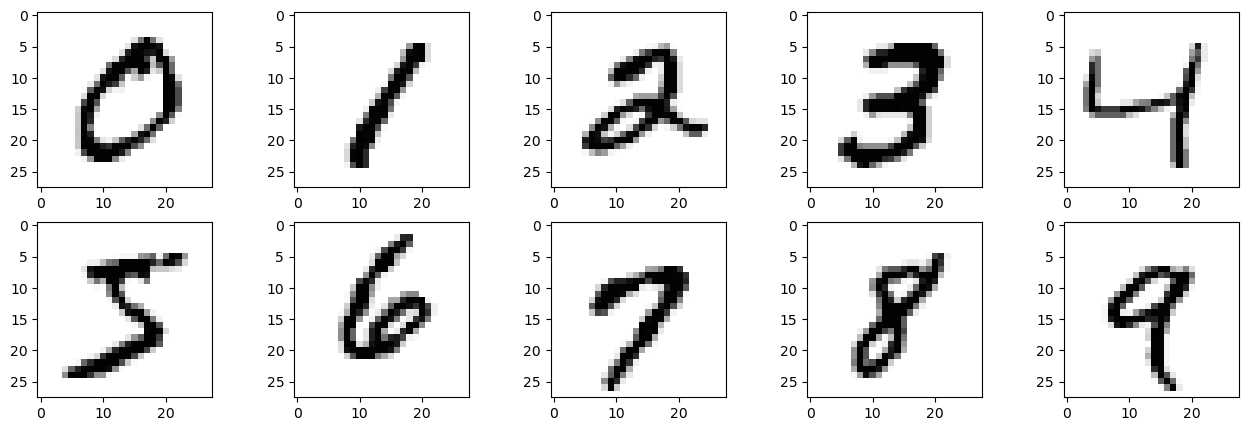

In [96]:
plt.figure(figsize=(16,5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    index_of_image = np.argwhere(train_set[1] == i)[0]
    plt.imshow(train_set[0][index_of_image].reshape((28, 28)), interpolation='nearest', cmap="Greys")

# Model

## KNN

First, we will create and fit a K-nearest neighbors algorithm.

In [118]:
data_location = f"s3://{write_bucket}/kmeans_highlevel_example/data"
output_location = f"s3://{write_bucket}/kmeans_example/output"

print(f"training data will be uploaded to: {data_location}")
print(f"training artifacts will be uploaded to: {output_location}")


knn = sagemaker.KNN(
    k=10,
    sample_size=train_set[0].shape[0],
    predictor_type='classifier',

    instance_count=1,
    instance_type="ml.c4.xlarge",
    role=sagemaker_role,

    output_path=output_location,
    data_location=data_location,
)

training data will be uploaded to: s3://sagemaker-eu-west-1-782668106505/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-eu-west-1-782668106505/kmeans_example/output


In [119]:
%%time

knn.fit(knn.record_set(train_set[0], labels=train_set[1]))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: knn-2023-12-11-16-10-31-664


2023-12-11 16:10:31 Starting - Starting the training job......
2023-12-11 16:11:10 Starting - Preparing the instances for training......
2023-12-11 16:12:19 Downloading - Downloading input data...
2023-12-11 16:12:44 Training - Downloading the training image..................


################## This Part is partially deleted ##################

2023-12-11 16:16:21 Uploading - Uploading generated training model
2023-12-11 16:16:21 Completed - Training job completed
Training seconds: 243
Billable seconds: 243
CPU times: user 12.1 s, sys: 589 ms, total: 12.7 s
Wall time: 6min 29s


In [319]:
knn_predictor = knn.deploy(initial_instance_count=1, instance_type="ml.r5.large")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: knn-2023-12-11-20-05-26-302
INFO:sagemaker:Creating endpoint-config with name knn-2023-12-11-20-05-26-302
INFO:sagemaker:Creating endpoint with name knn-2023-12-11-20-05-26-302


----------!

In [323]:
knn_predictions = knn_predictor.predict(test_set[0][:1000])

In [354]:
confusion_matrix_knn = confusion_matrix(test_set[1][:1000], [o.label["predicted_label"].float64_tensor.values[0] for o in knn_predictions], labels=list(range(10)))

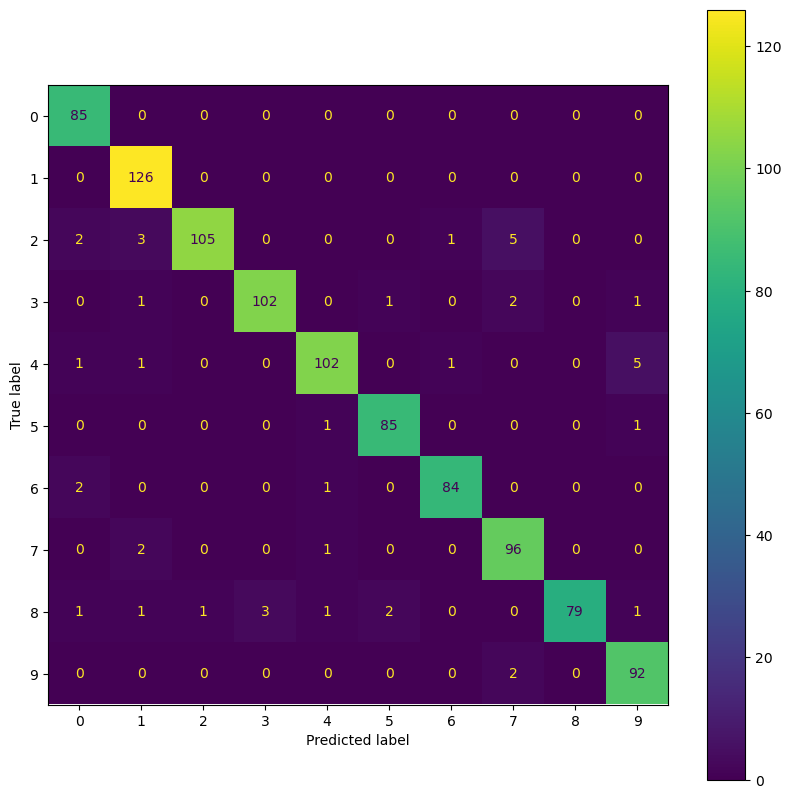

In [361]:
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=list(range(10)))
disp.plot(ax=ax)

# Autoencoder

*The following code is derived from https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder and https://www.kaggle.com/code/darkmistress/tensorflow-in-sagemaker#Training-Script---Create-Model*

First install TensorFlow

In [135]:
!pip install tensorflow -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Then write a script that will create, train and save the model

In [195]:
train_set[0].shape[1:]

(784,)

In [207]:
region

'eu-west-1'

In [233]:
write_bucket

'sagemaker-eu-west-1-782668106505'

In [246]:
%%writefile train.py

import argparse
import os
import json
import boto3

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import io
import pickle
import joblib

bucket = "sagemaker-eu-west-1-782668106505"
s3_client = boto3.client("s3", region_name='eu-west-1')

class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
          layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def create_model():
    # (784,)  train_set[0].shape[1:]
    model = Autoencoder(64, (784,))
    
    model.compile(optimizer='adam', loss=losses.MeanSquaredError())

    return model

def get_data(directory):
    bytes_set = io.BytesIO()
    s3_client.download_fileobj(bucket, 'autoencoder/data/train_set.pkl', bytes_set)
    bytes_set.seek(0)
    train_set = pickle.load(bytes_set)
    
    bytes_set = io.BytesIO()
    s3_client.download_fileobj(bucket, 'autoencoder/data/valid_set.pkl', bytes_set)
    bytes_set.seek(0)
    valid_set = pickle.load(bytes_set)
    
    return train_set, valid_set

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=16)
    # parser.add_argument('--steps', type=int, default=int(5873/16))
    # parser.add_argument('--val_steps', type=int, default=(1476/16))

    # input data and model directories
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    batch_size = args.batch_size
    
    model = create_model()
    
    train_data, valid_data = get_data(local_output_dir)

    history = model.fit(
        train_data, train_data,
        epochs=args.epochs,
        # steps_per_epoch=args.steps,
        shuffle=True,
        validation_data=(valid_data, valid_data),
        # validation_steps=args.val_steps
    )

    model.save(os.path.join(local_output_dir, 'model', '1'))

Overwriting train.py


Store both the train and validation sets, allowing them to be easily loaded in the script.

In [205]:
# https://stackoverflow.com/a/58083405/13165967

# upload without using disk
bytes_set = io.BytesIO()
pickle.dump(train_set[0], bytes_set)
bytes_set.seek(0)
s3_client.upload_fileobj(bytes_set, write_bucket, 'autoencoder/data/train_set.pkl')

# download without using disk
bytes_set2 = io.BytesIO()
s3_client.download_fileobj(write_bucket, 'autoencoder/data/train_set.pkl', bytes_set2)
bytes_set2.seek(0)
set2 = pickle.load(bytes_set2)

# check that everything is correct
np.allclose(train_set[0], set2)

True

In [206]:
# upload without using disk
bytes_set = io.BytesIO()
pickle.dump(valid_set[0], bytes_set)
bytes_set.seek(0)
s3_client.upload_fileobj(bytes_set, write_bucket, 'autoencoder/data/valid_set.pkl')

# download without using disk
bytes_set2 = io.BytesIO()
s3_client.download_fileobj(write_bucket, 'autoencoder/data/valid_set.pkl', bytes_set2)
bytes_set2.seek(0)
set2 = pickle.load(bytes_set2)

# check that everything is correct
np.allclose(valid_set[0], set2)

True

In [201]:
!pip freeze > requirements.txt

In [221]:
# https://stackoverflow.com/a/53532238/13165967
env = {
    'SAGEMAKER_REQUIREMENTS': 'requirements.txt', # path relative to `source_dir` below.
}

In [252]:
estimator = TensorFlow(
    entry_point='train.py',
    
    role=sagemaker_role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    
    framework_version='2.1.0',
    py_version='py3',

    source_dir = '.',
    env = env,
   
    output_path=f"s3://{write_bucket}/autoencoder"
)

In [253]:
%%time
estimator.fit()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-12-11-19-00-05-848


2023-12-11 19:01:29 Starting - Starting the training job......
2023-12-11 19:02:06 Starting - Preparing the instances for training...
2023-12-11 19:02:58 Downloading - Downloading input data...
2023-12-11 19:03:23 Training - Downloading the training image...
2023-12-11 19:03:39 Training - Training image download completed. Training in progress.2023-12-11 19:03:47,239 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training


################## This Part is partially deleted ##################

2023-12-11 19:05:21 Uploading - Uploading generated training model
2023-12-11 19:05:21 Completed - Training job completed
Training seconds: 142
Billable seconds: 142
CPU times: user 1min 13s, sys: 3.68 s, total: 1min 16s
Wall time: 5min 41s


## Test

download

In [254]:
s3_client.download_file("sagemaker-eu-west-1-782668106505", "autoencoder/tensorflow-training-2023-12-11-19-00-05-848/output/model.tar.gz", "model.tar.gz")

extract model file `.tar.gz`

In [261]:
import tarfile 
  
file = tarfile.open('model.tar.gz') 
  
file.extractall('.') 
# file.extract("model/1/saved_model.pb", ".")

file.close() 

In [263]:
model = tf.keras.models.load_model("./model/1")

INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


In [299]:
images = np.array([train_set[0][np.argwhere(train_set[1] == i)[0]] for i in range(10)]).reshape(10, 784)

In [300]:
encoded_images = model.encoder(images).numpy()
decoded_images = model.decoder(encoded_images).numpy()

In [305]:
print(images.shape[1], "->", encoded_images.shape[1], "->", decoded_images.shape[1])

784 -> 64 -> 784


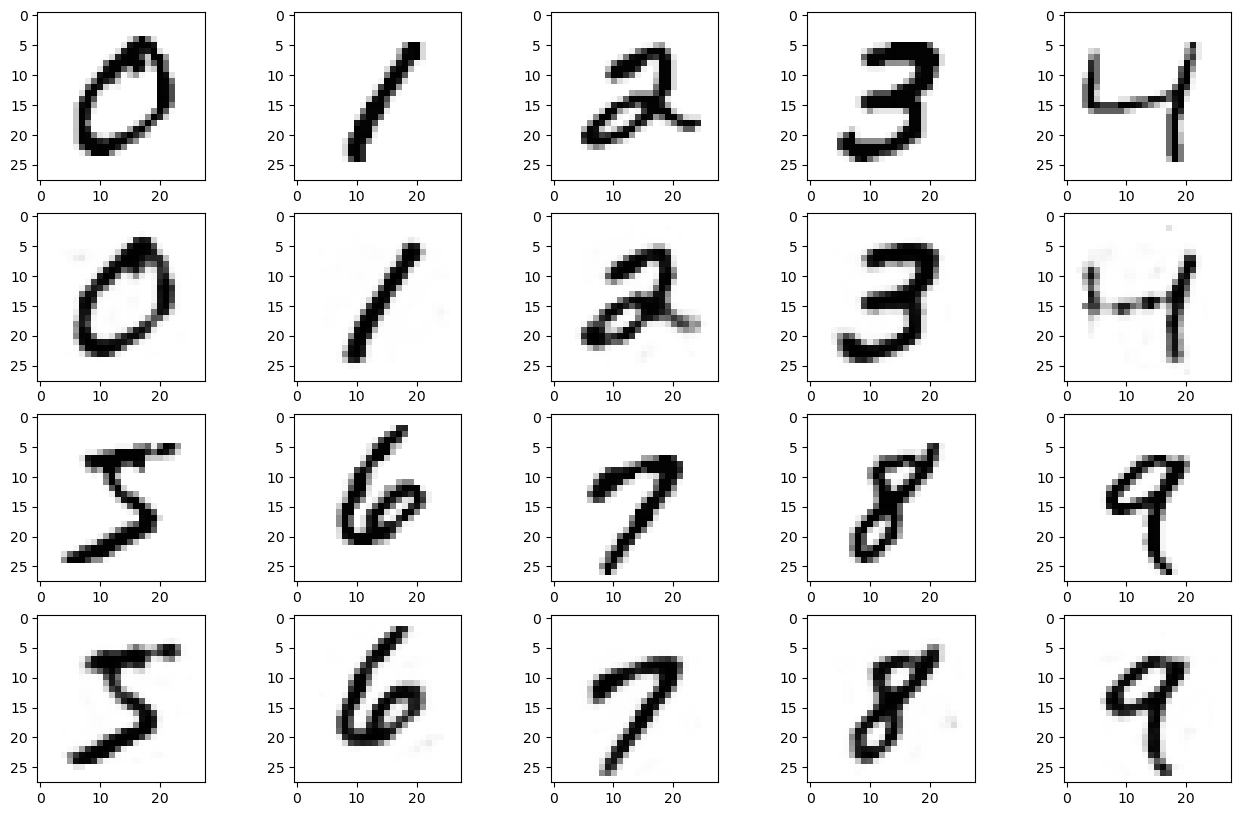

In [298]:
plt.figure(figsize=(16,10))

for i in range(5):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].reshape((28, 28)), interpolation='nearest', cmap="Greys")
    plt.subplot(4, 5, i + 1 + 5)
    plt.imshow(decoded_images[i].reshape((28, 28)), interpolation='nearest', cmap="Greys")

for i in range(5, 10):
    plt.subplot(4, 5, i + 1 + 5)
    plt.imshow(images[i].reshape((28, 28)), interpolation='nearest', cmap="Greys")
    plt.subplot(4, 5, i + 1 + 5 + 5)
    plt.imshow(decoded_images[i].reshape((28, 28)), interpolation='nearest', cmap="Greys")

## KNN - autoencoder

In [307]:
encoded_train_set = model.encoder(train_set[0]).numpy()

2023-12-11 19:56:34.722318: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156800000 exceeds 10% of free system memory.


In [313]:
data_location_autoencoder = f"s3://{write_bucket}/knn-autoencoder/data"
output_location_autoencoder = f"s3://{write_bucket}/knn-autoencoder/output"

print(f"training data will be uploaded to: {data_location_autoencoder}")
print(f"training artifacts will be uploaded to: {output_location_autoencoder}")


knn_autoencoder = sagemaker.KNN(
    k=10,
    sample_size=encoded_train_set.shape[0],
    predictor_type='classifier',

    instance_count=1,
    instance_type="ml.c4.xlarge",
    role=sagemaker_role,

    output_path=output_location_autoencoder,
    data_location=data_location_autoencoder,
)

training data will be uploaded to: s3://sagemaker-eu-west-1-782668106505/knn-autoencoder/data
training artifacts will be uploaded to: s3://sagemaker-eu-west-1-782668106505/knn-autoencoder/output


In [362]:
%%time

knn_autoencoder.fit(knn_autoencoder.record_set(encoded_train_set, labels=train_set[1]))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: knn-2023-12-11-20-21-23-346


2023-12-11 20:21:23 Starting - Starting the training job...
2023-12-11 20:21:38 Starting - Preparing the instances for training......
2023-12-11 20:22:50 Downloading - Downloading input data...
2023-12-11 20:23:14 Training - Downloading the training image........................


################## This Part is partially deleted ##################

2023-12-11 20:27:42 Uploading - Uploading generated training model
2023-12-11 20:27:42 Completed - Training job completed
Training seconds: 293
Billable seconds: 293
CPU times: user 2.67 s, sys: 181 ms, total: 2.85 s
Wall time: 6min 46s


In [364]:
knn_autoencoder_predictor = knn_autoencoder.deploy(initial_instance_count=1, instance_type="ml.r5.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: knn-2023-12-11-20-30-03-155
INFO:sagemaker:Creating endpoint-config with name knn-2023-12-11-20-30-03-155
INFO:sagemaker:Creating endpoint with name knn-2023-12-11-20-30-03-155


----------!

In [377]:
encoded_test_set = model.encoder(test_set[0]).numpy()

In [378]:
knn_autoencoder_predictions = knn_autoencoder_predictor.predict(encoded_test_set[:1000])

In [379]:
confusion_matrix_knn_autoencoder = confusion_matrix(test_set[1][:1000], [o.label["predicted_label"].float64_tensor.values[0] for o in knn_autoencoder_predictions], labels=list(range(10)))

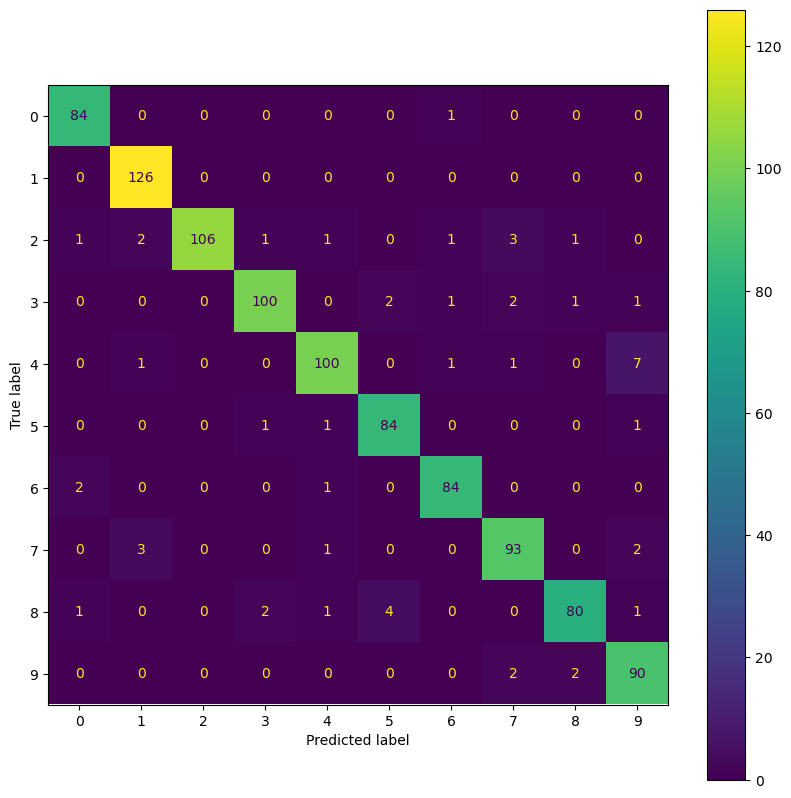

In [380]:
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn_autoencoder, display_labels=list(range(10)))
disp.plot(ax=ax)